In this notebook, we do exploratory analysis of our song lyrics dataset. We hope to discover interesting features of song lyrics which can help machine learning models predict song genres.

# Importing utilities

In [1]:
from utils import *
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings

# Importing data

In [2]:
data = pd.read_csv('data_final.csv')
data['category'] = data['category'].astype('category')
data

,name_pp,lyric_pp,category
0,world cold,start pain followed hate fueled endless questi...,ROCK
1,broken,freedom alone alone patiently waiting phone ho...,ROCK
2,leaf loser,biting hand feed lying voice inside reach beg ...,ROCK
3,anthem underdog,say know going togine wait across line thought...,ROCK
4,adrenaline,heart beating faster control feeling anymore w...,ROCK
...,...,...,...
20334,cocaine,want hang got take cocaine want get ground coc...,ROCK
20335,along watchtower,must kind way said joker thief much confusion ...,ROCK
20336,carry wayward son,carry wayward son peace done lay weary head re...,ROCK
20337,simple man,mama told young come sit beside son listen clo...,ROCK


## Song count

In [3]:
data['category'].value_counts()

COUNTRY    3390
INDIE      3390
JAZZ       3390
POP        3390
ROCK       3390
HIPHOP     3389
Name: category, dtype: int64

# Exploring the structure of song lyrics

`document_term_matrix` is a matrix storing the frequency of every word in every song in our dataset. Each row corresponds to a song and each column corresponds to a word.

Each word is defined as a sequence of word characters surrounded by non-word characters (per Unicode's definition). All words are converted to lowercase before counting takes place. This means that the sentence "I'm counting words." is considered to have 4 words: "i", "m", "counting", and "words".

In [4]:
count_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
document_term_matrix = count_vectorizer.fit_transform(data['lyric_pp'])

document_term_matrix

<20339x54740 sparse matrix of type '<class 'numpy.int64'>'
	with 1482042 stored elements in Compressed Sparse Row format>

## Word count

This section compares the word count of songs across genres. The comparison is illustrated by a table and a violin plot. In every violin plot in this notebook, the horizontal lines mark the minimum, mean, and maximum values.

In [5]:
data['word count'] = document_term_matrix.sum(axis=1).getA1()
word_count = data.groupby('category')['word count']
word_count.describe().drop('count', axis='columns')

,mean,std,min,25%,50%,75%,max
category,,,,,,,
COUNTRY,111.343068,49.233973,19.0,72.0,105.0,143.0,432.0
HIPHOP,272.822957,114.344446,26.0,194.0,267.0,343.0,975.0
INDIE,113.106785,59.485503,7.0,71.0,102.0,142.0,766.0
JAZZ,99.979646,67.023854,2.0,56.0,82.0,121.0,563.0
POP,128.869322,69.386234,4.0,81.0,117.0,159.0,756.0
ROCK,113.949263,46.198410,5.0,83.0,109.0,139.0,651.0


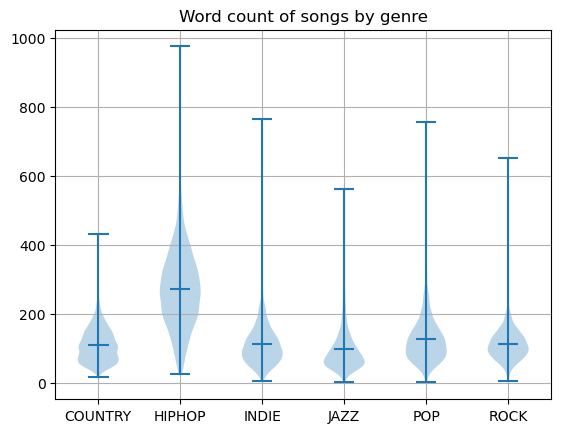

In [6]:
warnings.filterwarnings('ignore', category=UserWarning)
make_violin_plot(word_count, "Word count of songs by genre")

## Vocabulary size

This section analyzes the number of unique words in each song and visualizes the distribution of this measure for each genre.

In [7]:
data['vocab size'] = (document_term_matrix > 0).sum(axis=1).getA1()
vocab_size = data.groupby('category')['vocab size']
vocab_size.describe().drop('count', axis='columns')

,mean,std,min,25%,50%,75%,max
category,,,,,,,
COUNTRY,60.131858,24.241142,3.0,43.0,57.0,73.0,314.0
HIPHOP,151.046031,69.551169,5.0,101.0,147.0,194.0,592.0
INDIE,57.143953,29.771371,2.0,38.0,52.0,70.0,431.0
JAZZ,50.050442,33.812836,1.0,31.0,42.0,58.0,354.0
POP,60.241003,31.036164,2.0,43.0,54.0,70.0,487.0
ROCK,58.611799,27.172830,2.0,42.0,55.0,71.0,512.0


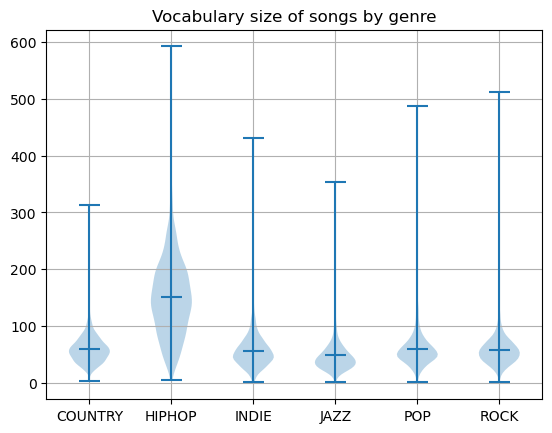

In [8]:
make_violin_plot(vocab_size, "Vocabulary size of songs by genre")

## Average word frequency

Here we calculate the average word frequency (word count divided by vocabulary size) of each song. Higher numbers mean words tend to be repeated more frequently.

In [9]:
data['average word frequency'] = data['word count'] / data['vocab size']
avg_word_freq = data.groupby('category')['average word frequency']
avg_word_freq.describe().drop('count', axis='columns')

,mean,std,min,25%,50%,75%,max
category,,,,,,,
COUNTRY,1.883908,0.593469,1.0,1.484960,1.800000,2.148936,12.666667
HIPHOP,1.932745,0.668247,1.0,1.502304,1.792857,2.186441,10.875000
INDIE,2.139096,1.406092,1.0,1.520208,1.904436,2.420789,48.000000
JAZZ,2.146603,2.714756,1.0,1.487947,1.869565,2.407407,147.000000
POP,2.242497,1.011183,1.0,1.617997,2.072585,2.632653,20.000000
ROCK,2.081927,0.817238,1.0,1.542745,1.907651,2.386913,13.500000


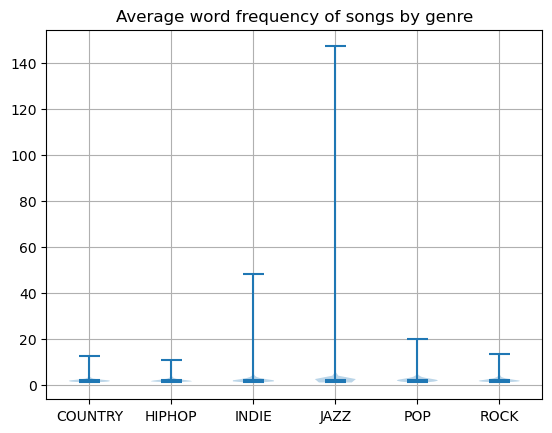

In [10]:
make_violin_plot(avg_word_freq, "Average word frequency of songs by genre")

# Exploring the meaning of song lyrics

In [11]:
genres = data['category'].unique()
vocab = count_vectorizer.get_feature_names_out()

This part computes the tf-idf of each word in each song in our dataset and finds the top 15 words with the highest average tf-idf for each genre. These words for each genre can be interpreted as the most important on average to the meaning of songs of the genre.

We're going to use the definitions $tf(term, document) = 1 + \log count(term, document)$ and $idf(term) = {\log \frac{#documents}{df(term)}}$.

In [13]:
tfidf_matrix = CustomTfidfTransformer(smooth_idf=False, sublinear_tf=True).fit(document_term_matrix).transform(document_term_matrix)

### Top-15-word charts

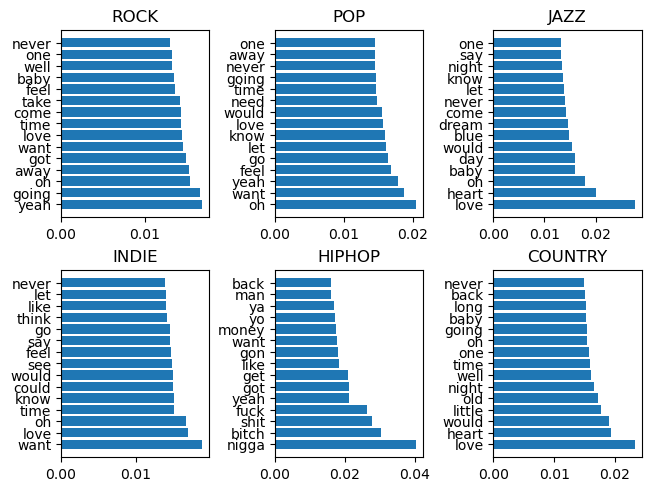

In [14]:
important_words_fig, important_words_axs = plt.subplots(2, 3, constrained_layout=True)
for i in range(len(genres)):
    genre_tfidf = tfidf_matrix[data['category'] == genres[i]].mean(axis=0).getA1()
    indices = np.argsort(- genre_tfidf)[:15]
    words = vocab[indices]
    tfidf_values = genre_tfidf[indices]
    axes = important_words_axs[divmod(i, 3)]
    axes.set_title(genres[i])
    axes.barh(words, tfidf_values)

### Word clouds

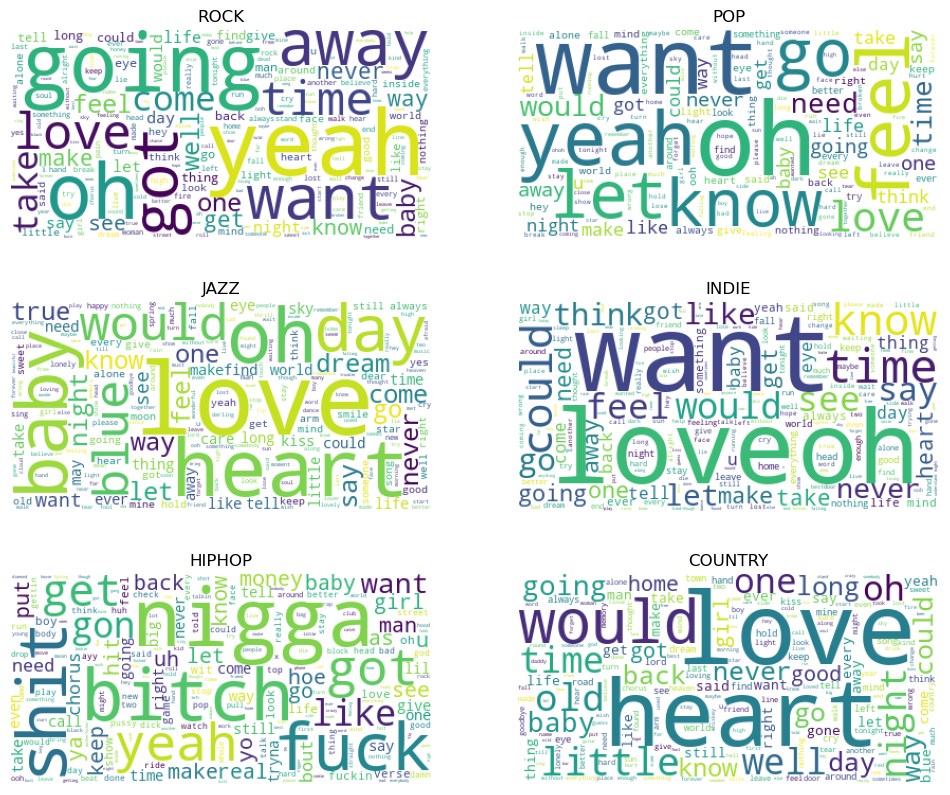

In [15]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
word_cloud_fig, word_cloud_axs = plt.subplots(3, 2, figsize=(12, 10))
for i in range(len(genres)):
    genre_tfidf = tfidf_matrix[data['category'] == genres[i]].mean(axis=0).getA1()
    indices = np.argsort(- genre_tfidf)
    word_cloud = WordCloud(background_color='white')
    word_cloud.generate_from_frequencies(dict(zip(vocab[indices], genre_tfidf[indices])))
    axes = word_cloud_axs[divmod(i, 2)]
    axes.set_title(genres[i])
    axes.grid(visible=False)
    axes.axis(False)
    axes.imshow(word_cloud)

## Latent semantic analysis

Here we reduce the tf-idf matrix to 100 dimensions using singular value decomposition to get a more computation-friendly and less noisy matrix for semantic analysis.

Reference: https://en.wikipedia.org/wiki/Latent_semantic_analysis

In [16]:
lsa = TruncatedSVD(n_components=100, random_state=0)
lsa_matrix = lsa.fit_transform(tfidf_matrix)
lsa_df = pd.DataFrame(lsa_matrix, index=data.index, columns=[f'tf-idf principal comp {i}' for i in range(lsa_matrix.shape[1])])
data = data.join(lsa_df)

We'll visualize the first 2 principal components of the LSA matrix for each genre.

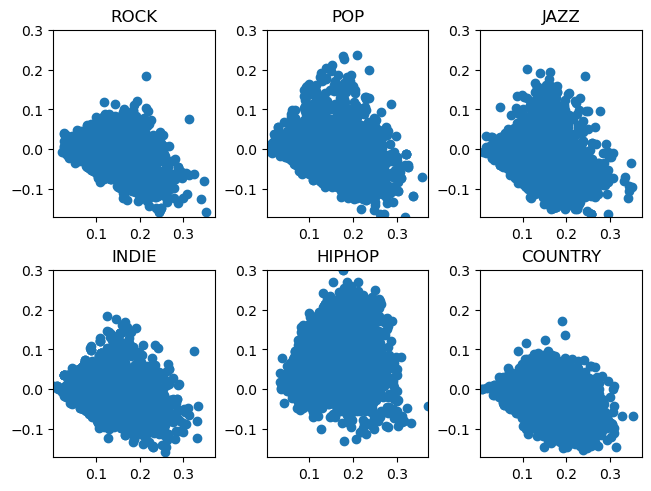

In [17]:
tfidf_pc1_min, tfidf_pc2_min = lsa_matrix[:, :2].min(axis=0)
tfidf_pc1_max, tfidf_pc2_max = lsa_matrix[:, :2].max(axis=0)
lsa_fig, lsa_axs = plt.subplots(2, 3, constrained_layout=True)
for i in range(len(genres)):
    genre_lsa_matrix = lsa_matrix[data['category'] == genres[i]]
    axes = lsa_axs[divmod(i, 3)]
    axes.set_title(genres[i])
    axes.set_xlim(tfidf_pc1_min, tfidf_pc1_max)
    axes.set_ylim(tfidf_pc2_min, tfidf_pc2_max)
    axes.scatter(genre_lsa_matrix[:, 0], genre_lsa_matrix[:, 1])

# Comparing features

This section examines the mutual information (MI) between some features computed above (word count, vocabulary size, average word frequency, and tf-idf principal components) and the target variable (genre).

Intuitively, the MI between two random variables measures the dependency between them, so if we were to use only one feature to predict a target variable, we should choose the feature that maximizes the MI between it and the target.

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [18]:
features = data.columns.drop(['name_pp', 'lyric_pp', 'category']) #103 features
mi_scores = mutual_info_classif(
    X=data[features], y=data['category'],
    discrete_features=(data[features].dtypes == 'int32') | (data[features].dtypes == 'int64'),
    random_state=0
)

<AxesSubplot:title={'center':'Top 20 features with highest mutual information with genre'}>

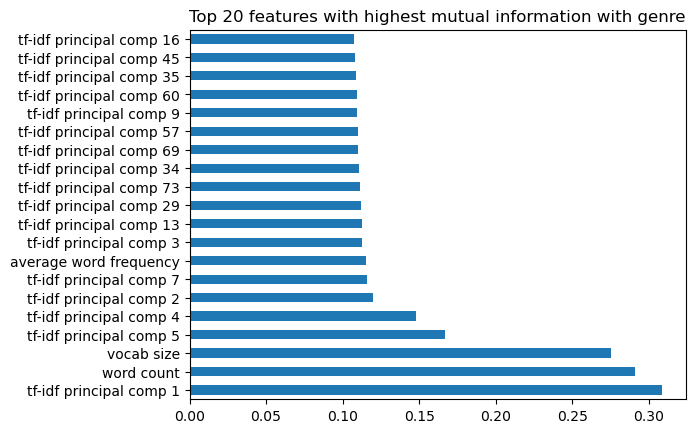

In [19]:
top_20_features = pd.Series(mi_scores, index=features).nlargest(n=20, keep='all')
top_20_features.plot.barh(title='Top 20 features with highest mutual information with genre')

### Testing these features with a SVM classifier

In the notebook `Model\ML_models.ipynb`, we've trained a Naive Bayes classifier, a linear SVM classifier, and an XGBoost classifier using raw tf-idf features. The SVM classifier achieved the best accuracy.

Here we're going to train a SVM classifier using the 103 features in `features` to see if they improve the model's performance.

In [20]:
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['category'], test_size=0.2, random_state=2023)

classifier = LinearSVC(
    C = 0.031, #penalty coefficient
)
classifier.fit(csr_matrix(X_train), Y_train)

Y_pred = classifier.predict(X_test)
accuracy = accuracy_score(Y_pred, Y_test)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.466322517207473


Now we're going to try only the top 20 features.

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(data[top_20_features.index], data['category'], test_size=0.2, random_state=2023)

classifier = LinearSVC(
    C = 0.031, #penalty coefficient
)
classifier.fit(csr_matrix(X_train), Y_train)

Y_pred = classifier.predict(X_test)
accuracy = accuracy_score(Y_pred, Y_test)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.341937069813176


It looks like the fewer features we use, the worse the SVM classifier performs :/